In [1]:
# Imports
import os,sys,inspect
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pandas as pd
import numpy as np
import zipfile
import seaborn as sns 
import matplotlib.dates as mdates
from time import time
import matplotlib.pyplot as plt
import plotly.offline as py 
%matplotlib inline
import random
import string
import re
import math

# Pre-processing
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict as cvp
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.ensemble import RandomForestClassifier
import keras
import tensorflow as tf
from tensorflow import keras

# Classification model
import tensorflow as tf
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVC
from sklearn.base import BaseEstimator
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

# Accuracy check
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score,f1_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import mean_squared_error
from plotly.offline import iplot, plot, init_notebook_mode
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Graph embedding
import networkx as nx
from networkx.algorithms.community.modularity_max import greedy_modularity_communities
from sklearn.metrics.pairwise import pairwise_distances
from gensim.models import Word2Vec
from networkx.algorithms.community.label_propagation import label_propagation_communities
# import community # python-louvain
import stellargraph as sg
from stellargraph import StellarGraph
from stellargraph.data import BiasedRandomWalk, UnsupervisedSampler
from stellargraph.mapper import Node2VecLinkGenerator, Node2VecNodeGenerator
from stellargraph.layer import Node2Vec as n2v_stellar
from stellargraph.layer import link_classification
from node2vec import Node2Vec as n2v

# Visualization 
import igraph as ig
import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import iplot, plot, init_notebook_mode
from bokeh.io import output_notebook, show, save
from bokeh.models import *
from bokeh.plotting import figure, show, from_networkx
from bokeh.palettes import viridis, Viridis8
from bokeh.transform import linear_cmap
from networkx.algorithms import community
from sklearn.manifold import TSNE
from IPython.display import display, HTML
from community import community_louvain
output_notebook()

# Ignore matplotlib warnings
import warnings
warnings.filterwarnings("ignore")

# Shared instances
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

from IPython.core.display import display, HTML
display(HTML("<style>.container {width:80% !important; }</style>"))

# Custom function
def plot_confusion_matrix(cm, class_labels):
    """Pretty prints a confusion matrix as a figure

    Args:
        cm:  A confusion matrix for example
        [[245, 5 ], 
         [ 34, 245]]
         
        class_labels: The list of class labels to be plotted on x-y axis

    Rerturns:
        Just plots the confusion matrix.
    """
    
    df_cm = pd.DataFrame(cm, index = [i for i in class_labels],
                  columns = [i for i in class_labels])
    sns.set(font_scale=1)
    sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')
    plt.xlabel("Predicted label")
    plt.ylabel("Real label")
    plt.show()
    
# Customized classification report including AUC
def class_report(y_true, y_pred, y_score=None, average='micro'):
    if y_true.shape != y_pred.shape:
        print("Error! y_true %s is not the same shape as y_pred %s" % (
              y_true.shape,
              y_pred.shape)
        )
        return

    lb = LabelBinarizer()

    if len(y_true.shape) == 1:
        lb.fit(y_true)

    #Value counts of predictions
    labels, cnt = np.unique(
        y_pred,
        return_counts=True)
    n_classes = len(labels)
    pred_cnt = pd.Series(cnt, index=labels)

    metrics_summary = precision_recall_fscore_support(
            y_true=y_true,
            y_pred=y_pred,
            labels=labels)

    avg = list(precision_recall_fscore_support(
            y_true=y_true,
            y_pred=y_pred,
            average='weighted'))
    
    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index,
        columns=labels)
    support = class_report_df.loc['support']
    total = support.sum()
    class_report_df['avg / total'] = avg[:-1] + [total]
    class_report_df = class_report_df.T
    class_report_df['pred'] = pred_cnt
    class_report_df['pred'].iloc[-1] = total
    if not (y_score is None):
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for label_it, label in enumerate(labels):
            fpr[label], tpr[label], _ = roc_curve(
                (y_true == label).astype(int),
                y_score[:, label_it])
            roc_auc[label] = auc(fpr[label], tpr[label])
        if average == 'micro':
            if n_classes <= 2:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                    lb.transform(y_true).ravel(),
                    y_score[:, 1].ravel())
            else:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                        lb.transform(y_true).ravel(),
                        y_score.ravel())
            roc_auc["avg / total"] = auc(
                fpr["avg / total"],
                tpr["avg / total"])
        elif average == 'macro':
            # First aggregate all false positive rates
            all_fpr = np.unique(np.concatenate([
                fpr[i] for i in labels]
            ))
            # Then interpolate all ROC curves at this points
            mean_tpr = np.zeros_like(all_fpr)
            for i in labels:
                mean_tpr += interp(all_fpr, fpr[i], tpr[i])
            # Finally average it and compute AUC
            mean_tpr /= n_classes
            fpr["macro"] = all_fpr
            tpr["macro"] = mean_tpr
            roc_auc["avg / total"] = auc(fpr["macro"], tpr["macro"])
        class_report_df['AUC'] = pd.Series(roc_auc)
    return class_report_df

def get_auc(y, y_pred_probabilities, class_labels, column =1, plot = True):
    fpr, tpr, _ = roc_curve(y == column, y_pred_probabilities[:,column],drop_intermediate = False)
    roc_auc = roc_auc_score(y_true=y, y_score=y_pred_probabilities[:,1])
    print ("AUC: ", roc_auc)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

/Users/d.gorgan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



Metal device set to: Apple M1 Pro


2022-06-12 00:21:15.225709: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-12 00:21:15.225903: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Loading BokehJS ...

In [2]:
# Load Dataframe 
sampled_trans_3w = pd.read_csv(r'sampled_trans_3w_M2.csv')
sampled_trans_3w.shape

(135759, 7)

In [3]:
sampled_trans_3w

,Unnamed: 0,input_address,output_address,weight,input_flag,output_flag,flag
0,0,1Hn2T8YqENLS9cPFevRjU38hUZw2GLvgmA,32tVDD6mHdQ2w5adeHmx1KR2V1qctzfgrW,1.0,0,0,0
1,1,12Qw1hKXZy2LJqFXEKzMy99KWikoJVHyUS,1GBYjzPaaTCBpDV8cMmGLVb1yGLgkBLJHw,1.0,0,0,0
2,2,12Qw1hKXZy2LJqFXEKzMy99KWikoJVHyUS,1MqcLZVEFbiHWgxae6z3QJkY4qc5MkfC6U,1.0,0,0,0
3,3,1AYnB5u8Z3fV1cm4gjVLPBr4jRHG3o4sFq,1Pc1EvxsHqUth93r1184v5Cq8yKpeBAZbH,1.0,0,0,0
4,4,1qw617dzi3mrtppoCYTV3UerTLNHyeFwo,16MczKNyB6vnsLW9EGn4B22bska8KiABod,1.0,0,0,0
...,...,...,...,...,...,...,...
135754,135754,3L2dbE145mkDNRoKiphrRBDsF2TZjEibFN,13g1jy1RM29dwdTD4jfRAVpVjcvwQLi9ov,1.0,0,0,0
135755,135755,3L2dbE145mkDNRoKiphrRBDsF2TZjEibFN,3ELpMR8unZHszrczKXmXyz2tKxpi1J99vh,1.0,0,0,0
135756,135756,3L2dbE145mkDNRoKiphrRBDsF2TZjEibFN,3MhjqpnJcSjLDkEFgFQpjsDk6UYZ7EV5GF,1.0,0,0,0
135757,135757,1pR2VTnHR1zYCpJbo4yJvnmTVdrLJSbBd,124Fd13TWAfpAXV2RJyW7j8KDVYfZSDZLM,1.0,0,0,0


In [4]:
# Load Dataframe 
sampled_nodes = pd.read_csv(r'sampled_nodes_M2.csv')
sampled_nodes = sampled_nodes.drop(['Unnamed: 0'], axis = 1)
sampled_nodes.shape

(50000, 6)

In [5]:
sampled_nodes

,input_address,degree,in_degree,out_degree,flag,self_loops
0,1Hn2T8YqENLS9cPFevRjU38hUZw2GLvgmA,2,0,2,0,0.0
1,12Qw1hKXZy2LJqFXEKzMy99KWikoJVHyUS,14,6,8,0,0.0
2,1Ny7csUTSdzrDCfTsoUXZxxeDn3WfeqqMq,1,1,0,0,0.0
3,1AYnB5u8Z3fV1cm4gjVLPBr4jRHG3o4sFq,3,1,2,0,0.0
4,1qw617dzi3mrtppoCYTV3UerTLNHyeFwo,59,34,25,0,0.0
...,...,...,...,...,...,...
49995,1PrSJE3VHw81LXZ293dMJc3wSVnPofjcfo,2,0,2,0,0.0
49996,1MsxW2Fj1id2jg5c6Jb5G7P1vCKvaxtPnm,6,3,3,0,0.0
49997,13CBGiqDPEoCRxwj1Kn1oz92LSEYQKLZ5C,150,146,4,0,0.0
49998,3L2dbE145mkDNRoKiphrRBDsF2TZjEibFN,14,1,13,0,0.0


In [6]:
# Load the graph
graph = nx.read_pajek('g_M2_50k.net')
print(f"The full network has {graph.number_of_nodes()} nodes.")
print(f"The full network has {graph.number_of_edges()} edges.")

The full network has 50000 nodes.
The full network has 135759 edges.


In [7]:
# Create the directed multigraph of the network using stellargraph library
graph = StellarGraph.from_networkx(graph)
graph.info()

'StellarDiGraph: Directed multigraph\n Nodes: 50000, Edges: 135759\n\n Node types:\n  default: [50000]\n    Features: none\n    Edge types: default-default->default\n\n Edge types:\n    default-default->default: [135759]\n        Weights: range=[2.94144e-05, 1], mean=0.776449, std=0.372216\n        Features: none'

### Node2Vec from stellargraph

In [8]:
# Generate random walks for mapping the network
walk_count = 5
walk_length = 4
karate_walk = BiasedRandomWalk(
    graph,
    n=walk_count,
    length=walk_length,
    p=0.5,  
    q=2.0, )

unsupervised_samples = UnsupervisedSampler(graph, nodes=list(graph.nodes()), walker=karate_walk)
batch_size = 32
epochs = 3
generator = Node2VecLinkGenerator(graph, batch_size)
emb_size = 64

In [9]:
# Train the model for embeddings size 100
node2vec = n2v_stellar(emb_size, generator=generator)
x_inp, x_out = node2vec.in_out_tensors()
predictions = prediction = link_classification(
    output_dim=1, output_act="sigmoid", edge_embedding_method="dot"
)(x_out)

model = keras.Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.binary_accuracy],)

link_classification: using 'dot' method to combine node embeddings into edge embeddings


In [10]:
# Fit the model
history = model.fit(
    generator.flow(unsupervised_samples),
    epochs=epochs,
    verbose=1,
    use_multiprocessing=False,
    workers=4,
    shuffle=True,)

Epoch 1/3


2022-06-12 00:21:43.701022: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-12 00:21:44.014921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


46875/46875 [==============================] - 1349s 29ms/step - loss: 0.5694 - binary_accuracy: 0.6498
Epoch 2/3
46875/46875 [==============================] - 695s 15ms/step - loss: 0.5013 - binary_accuracy: 0.7095
Epoch 3/3
46875/46875 [==============================] - 674s 14ms/step - loss: 0.5067 - binary_accuracy: 0.7233


In [11]:
x_inp_src = x_inp[0]
x_out_src = x_out[0]
embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)
unique_ids = np.unique(list(sampled_trans_3w["input_address"]) + 
                     list(sampled_trans_3w["output_address"]))
unique_ids = pd.DataFrame({"Node_ids":unique_ids })
unique_ids = pd.merge(unique_ids,sampled_trans_3w, how = "left", left_on = "Node_ids", right_on = "input_address")
unique_ids = pd.merge(unique_ids,sampled_trans_3w, how = "left", left_on = "Node_ids", right_on = "output_address")
unique_ids.head(10)

,Node_ids,Unnamed: 0_x,input_address_x,output_address_x,weight_x,input_flag_x,output_flag_x,flag_x,Unnamed: 0_y,input_address_y,output_address_y,weight_y,input_flag_y,output_flag_y,flag_y
0,11214Ka4PmBWz7un8zBGJrc7QcPmnMoBAb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19899.0,14tD8vmkMP9BLByfhyCW3XUBJXbGpVB8kd,11214Ka4PmBWz7un8zBGJrc7QcPmnMoBAb,1.0,0.0,0.0,0.0
1,11214Ka4PmBWz7un8zBGJrc7QcPmnMoBAb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35583.0,15SqKSqobQJdEZnv6RcqPSNnefgKbbfRVS,11214Ka4PmBWz7un8zBGJrc7QcPmnMoBAb,1.0,0.0,0.0,0.0
2,1124hGdY32pycKq35WfdQPBnhu2wH5ytN6,41971.0,1124hGdY32pycKq35WfdQPBnhu2wH5ytN6,115vHidYFfFvwvzVAszPi2q9a3qbR1FX2U,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1124hGdY32pycKq35WfdQPBnhu2wH5ytN6,41972.0,1124hGdY32pycKq35WfdQPBnhu2wH5ytN6,1NGw3gb943GJm6ph6ZVCLvEtVYKpHs785A,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1125hLHfQDkdRb9qtqZoAFqiqUmivzDf4u,74349.0,1125hLHfQDkdRb9qtqZoAFqiqUmivzDf4u,12anSUrVuNbm3y9dLA39ZVpMc4KvquShPc,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1125hLHfQDkdRb9qtqZoAFqiqUmivzDf4u,74350.0,1125hLHfQDkdRb9qtqZoAFqiqUmivzDf4u,1Dy2m5YXVPHZ7d8nfdSrrrXcjm7CowVG4d,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1126oQvWeWxabvyGNw5WeDBaiS1PHAD8Qt,103930.0,1126oQvWeWxabvyGNw5WeDBaiS1PHAD8Qt,1AQgPMr7rGZiDwo6QazDrzfaHvw8geMgoT,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1126vbZZhLwwwbATg2RyqoMdaChTWXx4sT,117811.0,1126vbZZhLwwwbATg2RyqoMdaChTWXx4sT,1atoJ6HRD8nT3i3q6tWDhjSE84NWADRMP,1.0,0.0,0.0,0.0,71409.0,1HUQdVG5Zf5JV9jKaxM1gn7M7ejpe2GMfN,1126vbZZhLwwwbATg2RyqoMdaChTWXx4sT,1.0,0.0,0.0,0.0
8,1128fAyGixrqX8DjRtLyfesZJgRWyS9htE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8638.0,1KNX1U8V1ydmUFRNxnesnn78Hk5wEuVUZE,1128fAyGixrqX8DjRtLyfesZJgRWyS9htE,1.0,0.0,0.0,0.0
9,112BQz7ca2uCMPqnSfXdYxKJ8o5vNXkeTm,50826.0,112BQz7ca2uCMPqnSfXdYxKJ8o5vNXkeTm,15mHyFmmxmxi1r5p1m9HHb8CQepQGiBAN1,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
source_vals = sampled_trans_3w[["input_address","flag"]].drop_duplicates()
source_vals.columns = ["Node_ID","flag"]
target_vals = sampled_trans_3w[["output_address","flag"]].drop_duplicates()
target_vals.columns = ["Node_ID","flag"]
testing = source_vals.append(target_vals)
testing = testing.drop_duplicates(subset = "Node_ID",keep = "first")
node_gen = Node2VecNodeGenerator(graph, batch_size).flow(graph.nodes())
node_embeddings = embedding_model.predict(node_gen, workers=4, verbose=1)

  80/1563 [>.............................] - ETA: 2s

2022-06-12 01:08:10.958283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1563/1563 [==============================] - 2s 1ms/step


In [13]:
print(pd.DataFrame(node_embeddings).shape)
pd.DataFrame(node_embeddings).head()

(50000, 64)


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.649959,-0.939935,-0.818312,0.778452,0.754836,0.293741,-0.143960,-1.123810,-0.215866,1.030127,...,1.084152,-0.870675,0.624868,-1.087986,-0.172917,-0.768926,1.168266,-0.975190,0.059914,-0.363470
1,0.867671,0.308833,-0.343908,-1.222439,0.358662,0.551802,-0.167944,1.131951,0.448069,0.145204,...,1.042886,-0.407551,0.385907,0.116703,-0.725759,0.223582,-0.615431,0.057971,0.656405,-0.443411
2,-0.935543,0.633282,0.069344,-0.398412,-0.762373,-0.552958,0.651925,-0.010781,0.429028,-0.807194,...,0.738699,-0.301311,-0.746637,-0.806384,0.022454,-0.614485,-0.456934,-0.771711,-1.158192,-0.707287
3,-1.117133,-0.463011,-0.583335,-0.237773,-0.487565,-1.043389,-0.217571,-0.451422,-0.202549,-0.819900,...,0.595370,0.819012,-0.130423,0.085810,-0.694418,0.397033,-0.404974,0.490708,-0.470159,-1.189768
4,-0.023387,-0.217173,0.591878,0.044102,0.250461,-0.244879,0.245989,-0.427570,1.068189,-0.740822,...,-0.622036,-0.837218,0.867730,-1.176267,1.012125,0.713571,0.929213,-0.402465,1.205010,0.627912


In [14]:
# Save to csv
node_embeddings_df = pd.DataFrame(node_embeddings)
print(node_embeddings_df.shape)
node_embeddings_df.to_csv("embeddings_M2_50k.csv")

(50000, 64)


### Add  fraudulent flag to embeddings

In [15]:
# Create the network dataset for further predictions
network = pd.concat([sampled_nodes, node_embeddings_df], axis=1)
network

,input_address,degree,in_degree,out_degree,flag,self_loops,0,1,2,3,...,54,55,56,57,58,59,60,61,62,63
0,1Hn2T8YqENLS9cPFevRjU38hUZw2GLvgmA,2,0,2,0,0.0,0.649959,-0.939935,-0.818312,0.778452,...,1.084152,-0.870675,0.624868,-1.087986,-0.172917,-0.768926,1.168266,-0.975190,0.059914,-0.363470
1,12Qw1hKXZy2LJqFXEKzMy99KWikoJVHyUS,14,6,8,0,0.0,0.867671,0.308833,-0.343908,-1.222439,...,1.042886,-0.407551,0.385907,0.116703,-0.725759,0.223582,-0.615431,0.057971,0.656405,-0.443411
2,1Ny7csUTSdzrDCfTsoUXZxxeDn3WfeqqMq,1,1,0,0,0.0,-0.935543,0.633282,0.069344,-0.398412,...,0.738699,-0.301311,-0.746637,-0.806384,0.022454,-0.614485,-0.456934,-0.771711,-1.158192,-0.707287
3,1AYnB5u8Z3fV1cm4gjVLPBr4jRHG3o4sFq,3,1,2,0,0.0,-1.117133,-0.463011,-0.583335,-0.237773,...,0.595370,0.819012,-0.130423,0.085810,-0.694418,0.397033,-0.404974,0.490708,-0.470159,-1.189768
4,1qw617dzi3mrtppoCYTV3UerTLNHyeFwo,59,34,25,0,0.0,-0.023387,-0.217173,0.591878,0.044102,...,-0.622036,-0.837218,0.867730,-1.176267,1.012125,0.713571,0.929213,-0.402465,1.205010,0.627912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,1PrSJE3VHw81LXZ293dMJc3wSVnPofjcfo,2,0,2,0,0.0,-0.476177,0.185577,-0.752222,0.005978,...,0.895223,0.984593,0.286767,0.308015,-0.222750,0.614100,0.317624,0.415277,0.653828,0.560009
49996,1MsxW2Fj1id2jg5c6Jb5G7P1vCKvaxtPnm,6,3,3,0,0.0,0.487321,0.809574,1.051007,1.176046,...,-0.579020,0.590216,-0.564507,0.090391,-0.674347,-0.641589,0.476909,-0.165006,0.544029,0.251776
49997,13CBGiqDPEoCRxwj1Kn1oz92LSEYQKLZ5C,150,146,4,0,0.0,0.380064,0.092665,-1.234961,0.419887,...,-0.961141,0.484492,1.264472,0.102913,0.026623,0.330023,0.922638,0.088972,1.197289,-0.276923
49998,3L2dbE145mkDNRoKiphrRBDsF2TZjEibFN,14,1,13,0,0.0,0.020705,0.677538,0.957472,-0.559561,...,0.935126,0.252079,-0.908284,0.240112,-0.576050,0.581997,0.394710,0.192947,0.720594,-0.191093


In [16]:
# Add header for features by renaming columns
column_group = {str(ii): "feature_" + str(ii+1) for ii in range(200)}

column_all = dict(column_group)
column_all = {int(jj): item_kk for jj,item_kk in column_all.items()}

network = network.rename(columns=column_all)
network

,input_address,degree,in_degree,out_degree,flag,self_loops,feature_1,feature_2,feature_3,feature_4,...,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64
0,1Hn2T8YqENLS9cPFevRjU38hUZw2GLvgmA,2,0,2,0,0.0,0.649959,-0.939935,-0.818312,0.778452,...,1.084152,-0.870675,0.624868,-1.087986,-0.172917,-0.768926,1.168266,-0.975190,0.059914,-0.363470
1,12Qw1hKXZy2LJqFXEKzMy99KWikoJVHyUS,14,6,8,0,0.0,0.867671,0.308833,-0.343908,-1.222439,...,1.042886,-0.407551,0.385907,0.116703,-0.725759,0.223582,-0.615431,0.057971,0.656405,-0.443411
2,1Ny7csUTSdzrDCfTsoUXZxxeDn3WfeqqMq,1,1,0,0,0.0,-0.935543,0.633282,0.069344,-0.398412,...,0.738699,-0.301311,-0.746637,-0.806384,0.022454,-0.614485,-0.456934,-0.771711,-1.158192,-0.707287
3,1AYnB5u8Z3fV1cm4gjVLPBr4jRHG3o4sFq,3,1,2,0,0.0,-1.117133,-0.463011,-0.583335,-0.237773,...,0.595370,0.819012,-0.130423,0.085810,-0.694418,0.397033,-0.404974,0.490708,-0.470159,-1.189768
4,1qw617dzi3mrtppoCYTV3UerTLNHyeFwo,59,34,25,0,0.0,-0.023387,-0.217173,0.591878,0.044102,...,-0.622036,-0.837218,0.867730,-1.176267,1.012125,0.713571,0.929213,-0.402465,1.205010,0.627912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,1PrSJE3VHw81LXZ293dMJc3wSVnPofjcfo,2,0,2,0,0.0,-0.476177,0.185577,-0.752222,0.005978,...,0.895223,0.984593,0.286767,0.308015,-0.222750,0.614100,0.317624,0.415277,0.653828,0.560009
49996,1MsxW2Fj1id2jg5c6Jb5G7P1vCKvaxtPnm,6,3,3,0,0.0,0.487321,0.809574,1.051007,1.176046,...,-0.579020,0.590216,-0.564507,0.090391,-0.674347,-0.641589,0.476909,-0.165006,0.544029,0.251776
49997,13CBGiqDPEoCRxwj1Kn1oz92LSEYQKLZ5C,150,146,4,0,0.0,0.380064,0.092665,-1.234961,0.419887,...,-0.961141,0.484492,1.264472,0.102913,0.026623,0.330023,0.922638,0.088972,1.197289,-0.276923
49998,3L2dbE145mkDNRoKiphrRBDsF2TZjEibFN,14,1,13,0,0.0,0.020705,0.677538,0.957472,-0.559561,...,0.935126,0.252079,-0.908284,0.240112,-0.576050,0.581997,0.394710,0.192947,0.720594,-0.191093


In [17]:
# Save to csv
network.to_csv("network_m2.csv")

### Visualise node embeddings

In [18]:
# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_embeddings)
node_targets = network['flag']

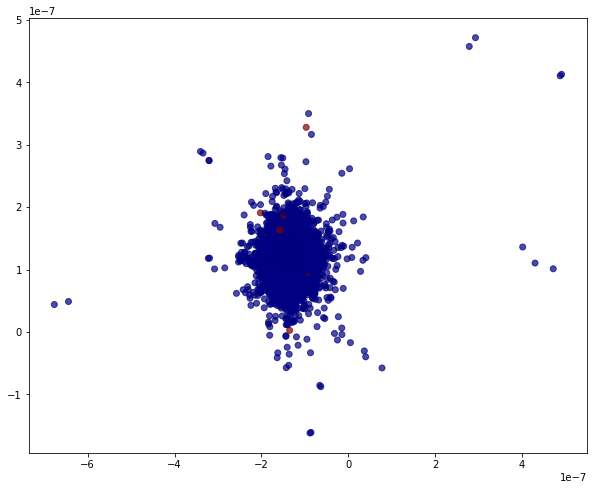

In [19]:
# Draw the points
alpha = 0.7
label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [label_map[target] for target in node_targets]

plt.figure(figsize=(10, 8))
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,)

# Step 5. Build classification model

In [20]:
network['flag'].value_counts()

0    49718
1      282
Name: flag, dtype: int64

In [21]:
# Drop address from csv
network = network.drop(['input_address', 'degree'], axis=1)

# Split target variable from its regressors
X = network.drop(['flag'], axis = 1)
y = network['flag']

# Reconvert back to dataframe from numpy array
X = pd.DataFrame(X)
X

,in_degree,out_degree,self_loops,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64
0,0,2,0.0,0.649959,-0.939935,-0.818312,0.778452,0.754836,0.293741,-0.143960,...,1.084152,-0.870675,0.624868,-1.087986,-0.172917,-0.768926,1.168266,-0.975190,0.059914,-0.363470
1,6,8,0.0,0.867671,0.308833,-0.343908,-1.222439,0.358662,0.551802,-0.167944,...,1.042886,-0.407551,0.385907,0.116703,-0.725759,0.223582,-0.615431,0.057971,0.656405,-0.443411
2,1,0,0.0,-0.935543,0.633282,0.069344,-0.398412,-0.762373,-0.552958,0.651925,...,0.738699,-0.301311,-0.746637,-0.806384,0.022454,-0.614485,-0.456934,-0.771711,-1.158192,-0.707287
3,1,2,0.0,-1.117133,-0.463011,-0.583335,-0.237773,-0.487565,-1.043389,-0.217571,...,0.595370,0.819012,-0.130423,0.085810,-0.694418,0.397033,-0.404974,0.490708,-0.470159,-1.189768
4,34,25,0.0,-0.023387,-0.217173,0.591878,0.044102,0.250461,-0.244879,0.245989,...,-0.622036,-0.837218,0.867730,-1.176267,1.012125,0.713571,0.929213,-0.402465,1.205010,0.627912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,2,0.0,-0.476177,0.185577,-0.752222,0.005978,0.047675,0.344367,-0.587936,...,0.895223,0.984593,0.286767,0.308015,-0.222750,0.614100,0.317624,0.415277,0.653828,0.560009
49996,3,3,0.0,0.487321,0.809574,1.051007,1.176046,0.231127,-0.308056,0.561303,...,-0.579020,0.590216,-0.564507,0.090391,-0.674347,-0.641589,0.476909,-0.165006,0.544029,0.251776
49997,146,4,0.0,0.380064,0.092665,-1.234961,0.419887,0.818691,0.074719,-0.050075,...,-0.961141,0.484492,1.264472,0.102913,0.026623,0.330023,0.922638,0.088972,1.197289,-0.276923
49998,1,13,0.0,0.020705,0.677538,0.957472,-0.559561,1.025617,0.347898,0.853293,...,0.935126,0.252079,-0.908284,0.240112,-0.576050,0.581997,0.394710,0.192947,0.720594,-0.191093


In [22]:
# Run correlogram to identify highly features
corr = X.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(3))

# Alternative
# corr = X.corr()
# corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,in_degree,out_degree,self_loops,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64
in_degree,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
out_degree,0.259,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
self_loops,0.141,0.558,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
feature_1,0.006,0.002,-0.007,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
feature_2,0.002,0.000,0.000,0.001,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
feature_3,0.009,0.004,-0.001,0.006,0.002,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
feature_4,-0.002,-0.008,-0.009,-0.005,-0.013,-0.023,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
feature_5,0.013,0.008,0.004,0.010,0.002,0.009,-0.022,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
feature_6,0.005,-0.006,-0.002,0.004,0.007,0.007,-0.009,0.005,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
feature_7,0.009,0.002,0.007,0.014,0.016,0.006,-0.018,0.012,0.007,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [23]:
# Split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(
        X_train.shape, y_train.shape, X_test.shape, y_test.shape))

class_labels = ['Licit', 'Illicit']

Array shapes:
 X_train = (40000, 67)
 y_train = (40000,)
 X_test = (10000, 67)
 y_test = (10000,)


In [24]:
# Generate new samples by randomly sampling with replacement the underrepresented class
sampling_strategy = 0.5
over = RandomOverSampler(sampling_strategy = sampling_strategy)
X_train, y_train = over.fit_resample(X_train, y_train) 

y_train.value_counts()

0    39775
1    19887
Name: flag, dtype: int64

In [25]:
# Generate new samples by decreasing the majority class
under = RandomUnderSampler(sampling_strategy = 0.9)
X_train, y_train = under.fit_resample(X_train, y_train) 

y_train.value_counts()

0    22096
1    19887
Name: flag, dtype: int64

In [26]:
y_test.value_counts()

0    9943
1      57
Name: flag, dtype: int64

#### Basic Logistic Regression

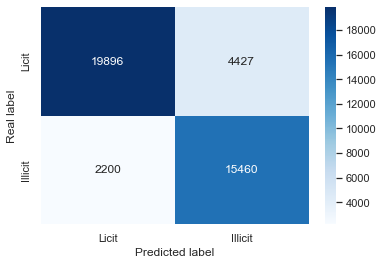

             precision    recall  f1-score  support     pred       AUC
0             0.817991  0.900434  0.857235  22096.0  24323.0  0.907419
1             0.875425  0.777392  0.823501  19887.0  17660.0  0.907419
avg / total   0.845197  0.842150  0.841256  41983.0  41983.0  0.907419


In [27]:
# Logistic Regression classifier
classifier = LogisticRegression()

# Producing predictions
classifier.fit(X_train, y_train)
y_train_pred = classifier.predict(X_train)
y_test_pred = classifier.predict(X_test)

# Computing the predicted probabilities 
y_train_probab = classifier.predict_proba(X_train)
y_test_probab = classifier.predict_proba(X_test)

# Computing the confusion matrix to assess in-sample misclassification errors (false positives and false negatives)
cm =  confusion_matrix(y_train_pred, y_train)

# Plotting confusion matrix 
plot_confusion_matrix(cm, class_labels)

# Customized classification report including AUC
report_with_auc = class_report(
    y_true = y_train, 
    y_pred = y_train_pred, 
    y_score = y_train_probab)
print(report_with_auc)

# We want to penalise false negatives, so we should be looking at recall (and maybe f1) as scorers
# False negatives would show any illicit nodes that were marked as licit. That's what anyone who reports to a regulator would care about. Recall would work best here
# F1 considers both false negatives and positives, so we can argue that this shows how a company would balance business and regulation

AUC:  0.9074193113975934


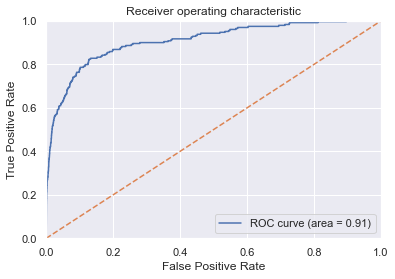

In [28]:
# Assess expected accuracy using AUC/ROC 
get_auc(y_train, y_train_probab, class_labels, column=1, plot=True)

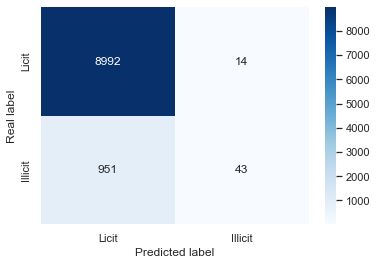

AUC:  0.9039719382938892


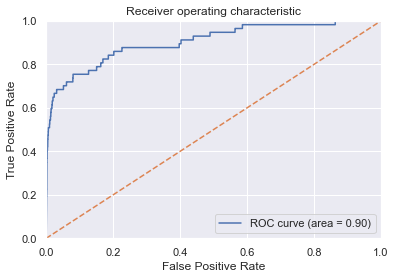

             precision    recall  f1-score  support     pred       AUC
0             0.998445  0.904355  0.949074   9943.0   9006.0  0.903972
1             0.043260  0.754386  0.081827     57.0    994.0  0.903972
avg / total   0.993001  0.903500  0.944131  10000.0  10000.0  0.903972


In [29]:
# Out-sample performance
cm =  confusion_matrix(y_test_pred, y_test)
plot_confusion_matrix(cm, class_labels)

# Assess expected accuracy using AUC/ROC 
get_auc(y_test, y_test_probab, class_labels, column=1, plot=True)

# Customized classification report including AUC
report_with_auc = class_report(
    y_true = y_test, 
    y_pred = y_test_pred, 
    y_score = y_test_probab)
print(report_with_auc)

#### Random Forest with tunned parameters
A random forest ensambles over decision trees. This takes the average of many decision trees using bagging, i.e. “bootstrap aggregation,” meaning that samples are chosen with replacement, and combined by taking their average. This reduces sampling bias.

In [30]:
# Instanciate Model
forest = RandomForestClassifier() 

# Hyperparameters grid
forest_params = {'n_estimators': range(50, 100), # standard range of trees to estimate
                 'max_features': range(4, 30), # Range around sqrt of #features and the total #features
                 'max_depth': range(3, 10), # deafult=None, capping max depth can reduce over-fitting
                 'min_samples_split': range(2, 10), # default=2, larger samples can guard against over-fitting
                 'min_samples_leaf': range(2, 10), # default=1, larger samples can guard against over-fitting
                 'bootstrap': [True]} # bootstrap=True reduces over-fitting by also sampling across observations
                 
# Instantiate RandomisedSearch
rforest = RandomizedSearchCV(forest, param_distributions=forest_params, scoring='recall',  
                             n_jobs=-1, random_state=42, cv=10)

# Fit RandomisedSearch to training data
rforest.fit(X_train, y_train)

y_train_pred = rforest.predict(X_train)
y_test_pred = rforest.predict(X_test)

# Computing the predicted probabilities 
y_train_probab = rforest.predict_proba(X_train)
y_test_probab = rforest.predict_proba(X_test)

# List best hyperparameters
print("Best estimators for Random Forest:\n", rforest.best_estimator_)

Best estimators for Random Forest:
 RandomForestClassifier(max_depth=9, max_features=10, min_samples_leaf=9,
                       min_samples_split=6, n_estimators=80)


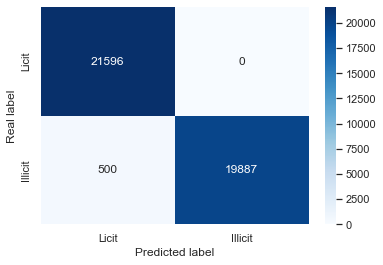

AUC:  0.9989609263919712


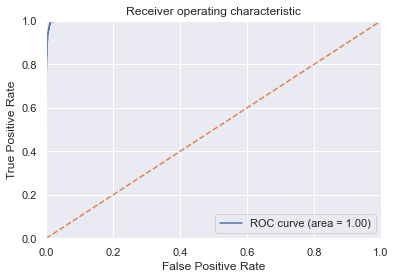

             precision    recall  f1-score  support     pred       AUC
0             1.000000  0.977371  0.988556  22096.0  21596.0  0.998961
1             0.975475  1.000000  0.987585  19887.0  20387.0  0.998961
avg / total   0.988383  0.988090  0.988096  41983.0  41983.0  0.998961


In [31]:
# In sample accuracy
cm =  confusion_matrix(y_train_pred, y_train)
plot_confusion_matrix(cm, class_labels)

# Assess expected accuracy using AUC/ROC 
get_auc(y_train, y_train_probab, class_labels, column=1, plot=True)

# Customized classification report including AUC
report_with_auc = class_report(
    y_true = y_train, 
    y_pred = y_train_pred, 
    y_score = y_train_probab)
print(report_with_auc)

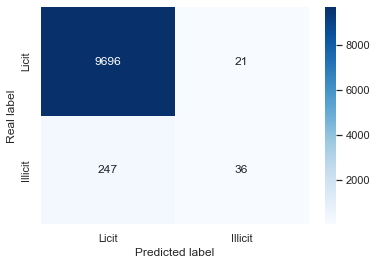

AUC:  0.9368893923433748


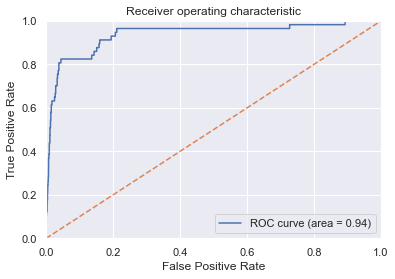

             precision    recall  f1-score  support     pred       AUC
0             0.997839  0.975158  0.986368   9943.0   9717.0  0.936889
1             0.127208  0.631579  0.211765     57.0    283.0  0.936889
avg / total   0.992876  0.973200  0.981953  10000.0  10000.0  0.936889


In [32]:
# Out-sample performance
cm =  confusion_matrix(y_test_pred, y_test)
plot_confusion_matrix(cm, class_labels)

# Assess expected accuracy using AUC/ROC 
get_auc(y_test, y_test_probab, class_labels, column=1, plot=True)

# Customized classification report including AUC
report_with_auc = class_report(
    y_true = y_test, 
    y_pred = y_test_pred, 
    y_score = y_test_probab)
print(report_with_auc)

In [59]:
# # Estimate out-sample acurracy
# accuracies = cross_val_score(estimator=rforest, X=X_test, y=y_test, cv=10, n_jobs=-1)
# print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
# print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

In [48]:
SEED = 4
# models
models = [XGBClassifier(),
          RandomForestClassifier(),
          AdaBoostClassifier(),
          GradientBoostingClassifier()]

# models parameters
xgb_params = {'objective':['reg:squarederror'],
                  'learning_rate': [0.05, 1],
                  'max_depth': range(3, 10),
                  'min_child_weight': range(5, 10),
                  'reg_lambda':[1.5],
                  'seed': [SEED]}

randomforest_params = {'max_features': range(4, 10),
                  'n_estimators': [50, 100],
                  'max_depth': range(3, 6),
                  'min_samples_leaf': range(5, 10),
                  'random_state': [SEED]}

adab_params = {'learning_rate': [0.05, 1],
                  'n_estimators': [50, 100],
                  'random_state': [SEED]}

gb_params = {'learning_rate': [0.05, 1],
                  'n_estimators': [50, 100],
                  'max_depth': range(3, 6),
                'max_features': range(4, 10),
                  'random_state': [SEED]}

params = [xgb_params, randomforest_params, adab_params, gb_params]
names = ['XGBClassifier', 'RandomForestClassifier', 'AdaBoostClassifier',
        'GradientBoostingClassifier']   
scores = {}

# gridsearch
for i, model in enumerate(models):
    print(f"Grid-Searching for model {names[i]}...")
    best_model = GridSearchCV(model, params[i], n_jobs=4, cv=5, 
                              scoring='neg_mean_squared_error', verbose = 0)
    best_model.fit(X_train, y_train)
    print(f"Best model fitted")
    y_train_pred = best_model.predict(X_train)
    
    mse = mean_squared_error(y_train, y_train_pred)
    # assign the best parameters to the models
    models[i].set_params(**best_model.best_params_)
    
    # print scores
    scores[names[i]] = (best_model.best_estimator_, mse)
    print(f'{names[i]} chosen hyperparameters: {best_model.best_params_}')
    print(f'{names[i]} Score on train sample: {-best_model.best_score_}')
    print(f'{names[i]} MSE score on test sample: {mse}\n')

Grid-Searching for model XGBClassifier...


/Users/d.gorgan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/d.gorgan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/d.gorgan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype inst

/Users/d.gorgan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/d.gorgan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/d.gorgan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype inst

/Users/d.gorgan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/d.gorgan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/d.gorgan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype inst

/Users/d.gorgan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/d.gorgan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/d.gorgan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype inst

/Users/d.gorgan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/d.gorgan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/d.gorgan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this

/Users/d.gorgan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/d.gorgan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/d.gorgan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this

/Users/d.gorgan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/d.gorgan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/d.gorgan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this

/Users/d.gorgan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/d.gorgan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/d.gorgan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this

/Users/d.gorgan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/d.gorgan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/d.gorgan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this

/Users/d.gorgan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/d.gorgan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/d.gorgan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this

/Users/d.gorgan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/d.gorgan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/d.gorgan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this

/Users/d.gorgan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/d.gorgan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/d.gorgan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this

Best model fitted
XGBClassifier chosen hyperparameters: {'learning_rate': 0.05, 'max_depth': 8, 'min_child_weight': 7, 'objective': 'reg:squarederror', 'reg_lambda': 1.5, 'seed': 4}
XGBClassifier Score on train sample: 1.934235976789168e-05
XGBClassifier MSE score on test sample: 1.934161154307377e-05

Grid-Searching for model RandomForestClassifier...
Best model fitted
RandomForestClassifier chosen hyperparameters: {'max_depth': 5, 'max_features': 9, 'min_samples_leaf': 7, 'n_estimators': 50, 'random_state': 4}
RandomForestClassifier Score on train sample: 0.22053300256233427
RandomForestClassifier MSE score on test sample: 0.21678078217477081

Grid-Searching for model AdaBoostClassifier...
Best model fitted
AdaBoostClassifier chosen hyperparameters: {'learning_rate': 1, 'n_estimators': 100, 'random_state': 4}
AdaBoostClassifier Score on train sample: 0.14846625804739244
AdaBoostClassifier MSE score on test sample: 0.1398205098448803

Grid-Searching for model GradientBoostingClassifie

Best model fitted
XGBClassifier chosen hyperparameters: {'learning_rate': 0.05, 'max_depth': 8, 'min_child_weight': 7, 'objective': 'reg:squarederror', 'reg_lambda': 1.5, 'seed': 4}
XGBClassifier Score on train sample: 1.934235976789168e-05
XGBClassifier MSE score on test sample: 1.934161154307377e-05

Grid-Searching for model RandomForestClassifier...
Best model fitted
RandomForestClassifier chosen hyperparameters: {'max_depth': 5, 'max_features': 9, 'min_samples_leaf': 7, 'n_estimators': 50, 'random_state': 4}
RandomForestClassifier Score on train sample: 0.22053300256233427
RandomForestClassifier MSE score on test sample: 0.21678078217477081

Grid-Searching for model AdaBoostClassifier...
Best model fitted
AdaBoostClassifier chosen hyperparameters: {'learning_rate': 1, 'n_estimators': 100, 'random_state': 4}
AdaBoostClassifier Score on train sample: 0.14846625804739244
AdaBoostClassifier MSE score on test sample: 0.1398205098448803

Grid-Searching for model GradientBoostingClassifier...
Best model fitted
GradientBoostingClassifier chosen hyperparameters: {'learning_rate': 1, 'max_depth': 5, 'max_features': 5, 'n_estimators': 100, 'random_state': 4}
GradientBoostingClassifier Score on train sample: 0.0010057709102206632
GradientBoostingClassifier MSE score on test sample: 0.0

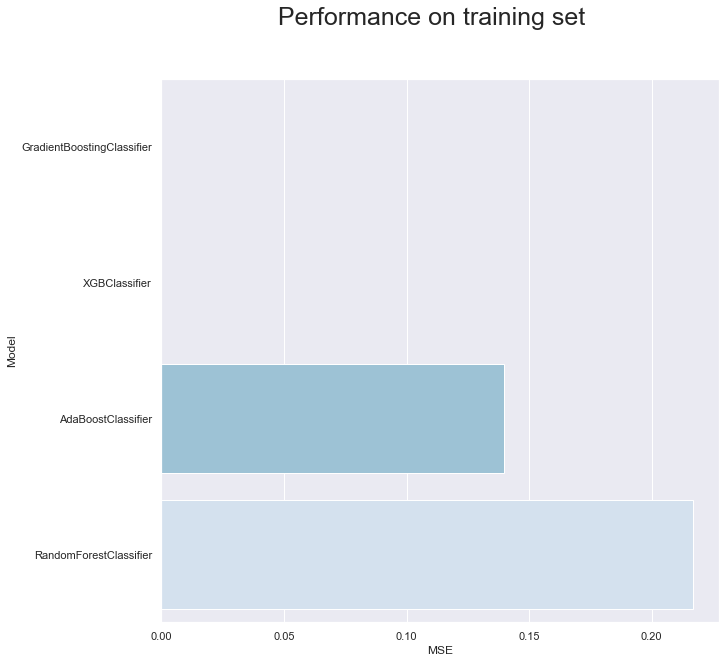

In [49]:
# Ranking the accuracy of the models based on Mean Squared Error
ranking = pd.DataFrame.from_dict(scores, orient='index').reset_index()

ranking.columns = ['Model', 'Setting', 'MSE']
ranking = ranking.sort_values(by='MSE', ascending=True).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(10, 10))
fig.suptitle("Performance on training set", fontsize=25)
sns.barplot(x="MSE", y="Model", data=ranking, ax=ax, palette = 'Blues_r');

In [50]:
# Make predictions
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Computing the predicted probabilities 
y_train_probab = best_model.predict_proba(X_train)
y_test_probab = best_model.predict_proba(X_test)

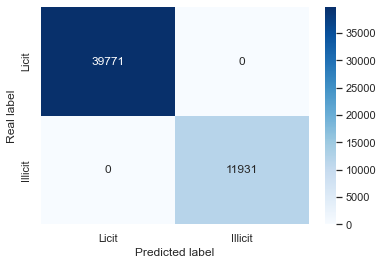

AUC:  1.0


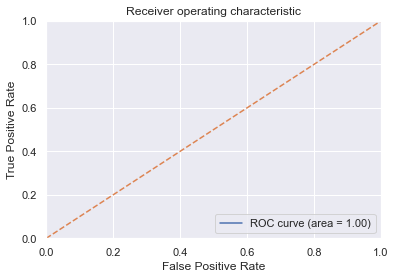

             precision  recall  f1-score  support     pred  AUC
0                  1.0     1.0       1.0  39771.0  39771.0  1.0
1                  1.0     1.0       1.0  11931.0  11931.0  1.0
avg / total        1.0     1.0       1.0  51702.0  51702.0  1.0


In [51]:
# In sample accuracy
cm =  confusion_matrix(y_train_pred, y_train)
plot_confusion_matrix(cm, class_labels)

# Assess expected accuracy using AUC/ROC 
get_auc(y_train, y_train_probab, class_labels, column=1, plot=True)

# Customized classification report including AUC
report_with_auc = class_report(
    y_true = y_train, 
    y_pred = y_train_pred, 
    y_score = y_train_probab)
print(report_with_auc)

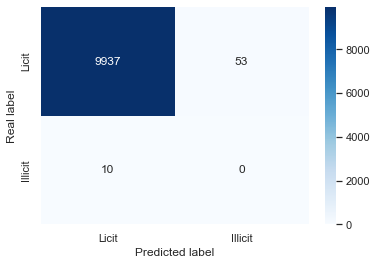

AUC:  0.5218051901493007


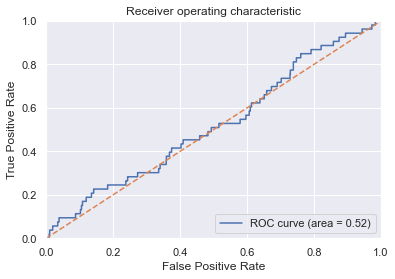

             precision    recall  f1-score  support     pred       AUC
0             0.994695  0.998995  0.996840   9947.0   9990.0  0.521805
1             0.000000  0.000000  0.000000     53.0     10.0  0.521805
avg / total   0.989423  0.993700  0.991557  10000.0  10000.0  0.521805


In [52]:
# Out-sample performance
cm =  confusion_matrix(y_test_pred, y_test)
plot_confusion_matrix(cm, class_labels)

# Assess expected accuracy using AUC/ROC 
get_auc(y_test, y_test_probab, class_labels, column=1, plot=True)

# Customized classification report including AUC
report_with_auc = class_report(
    y_true = y_test, 
    y_pred = y_test_pred, 
    y_score = y_test_probab)
print(report_with_auc)